In [1]:
from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [2]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [3]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [4]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

In [5]:
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print ("Total dataset size:")
print ("n_samples: %d" % n_samples)
print ("n_features: %d" % n_features)
print ("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 250

In [7]:
print ("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
print ("done in %0.3fs" % (time() - t0))

Extracting the top 250 eigenfaces from 966 faces
done in 1.549s


In [8]:
print(pca.explained_variance_ratio_)

[1.9346537e-01 1.5116848e-01 7.0836753e-02 5.9517939e-02 5.1574945e-02
 2.8871553e-02 2.5144828e-02 2.1764679e-02 2.0193789e-02 1.9021239e-02
 1.6822115e-02 1.5805980e-02 1.2233641e-02 1.0879363e-02 1.0644499e-02
 9.7965235e-03 8.9239888e-03 8.5484423e-03 8.3571076e-03 7.2263512e-03
 6.9656912e-03 6.5385639e-03 6.3955830e-03 5.6131636e-03 5.3110765e-03
 5.2015265e-03 5.0746608e-03 4.8420886e-03 4.4358857e-03 4.1782977e-03
 3.9370432e-03 3.8172840e-03 3.5606106e-03 3.5120081e-03 3.3455596e-03
 3.2993045e-03 3.1462598e-03 2.9621713e-03 2.9013536e-03 2.8472261e-03
 2.8000383e-03 2.6755547e-03 2.5990079e-03 2.5840087e-03 2.4091911e-03
 2.3899432e-03 2.3540340e-03 2.2258721e-03 2.1750731e-03 2.1656605e-03
 2.0906394e-03 2.0542603e-03 2.0042136e-03 1.9739564e-03 1.9383020e-03
 1.8876367e-03 1.8017266e-03 1.7889747e-03 1.7481932e-03 1.7305389e-03
 1.6564677e-03 1.6294768e-03 1.5740950e-03 1.5342927e-03 1.4996541e-03
 1.4726265e-03 1.4393154e-03 1.4188234e-03 1.3969804e-03 1.3814773e-03
 1.340

In [9]:
eigenfaces = pca.components_.reshape((n_components, h, w))

In [10]:
print ("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print ("done in %0.3fs" % (time() - t0))

Projecting the input data on the eigenfaces orthonormal basis
done in 0.121s


In [11]:
###############################################################################
# Train a SVM classification model

print ("Fitting the classifier to the training set")
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print ("done in %0.3fs" % (time() - t0))
print ("Best estimator found by grid search:")
print (clf.best_estimator_)

Fitting the classifier to the training set
done in 107.511s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)


In [12]:
###############################################################################
# Quantitative evaluation of the model quality on the test set

print ("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print ("done in %0.3fs" % (time() - t0))

print (classification_report(y_test, y_pred, target_names=target_names))
print (confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting the people names on the testing set
done in 0.168s
                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.69      0.67        13
     Colin Powell       0.75      0.90      0.82        60
  Donald Rumsfeld       0.82      0.67      0.73        27
    George W Bush       0.91      0.92      0.91       146
Gerhard Schroeder       0.87      0.80      0.83        25
      Hugo Chavez       0.80      0.53      0.64        15
       Tony Blair       0.82      0.78      0.80        36

         accuracy                           0.84       322
        macro avg       0.80      0.76      0.77       322
     weighted avg       0.84      0.84      0.84       322

[[  9   1   1   2   0   0   0]
 [  1  54   2   2   0   1   0]
 [  2   3  18   3   0   0   1]
 [  1   6   1 134   1   1   2]
 [  0   2   0   1  20   0   2]
 [  0   4   0   2   0   8   1]
 [  1   2   0   3   2   0  28]]


In [13]:
###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

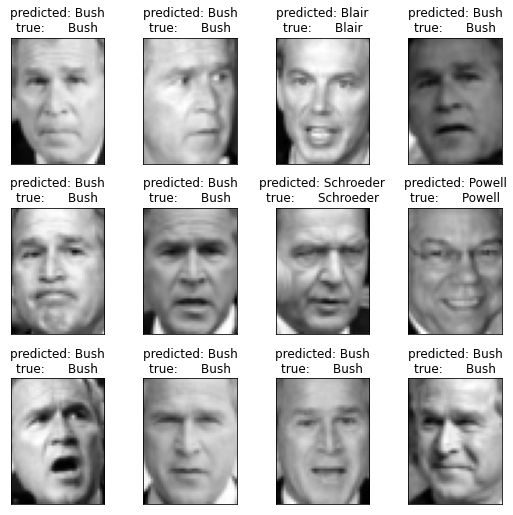

In [14]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

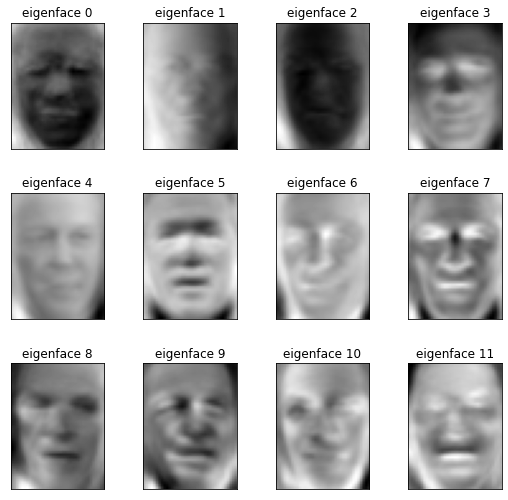

In [15]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()
